<a href="https://colab.research.google.com/github/marclamberts/football-analysis/blob/main/Scanning_Quality_Score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


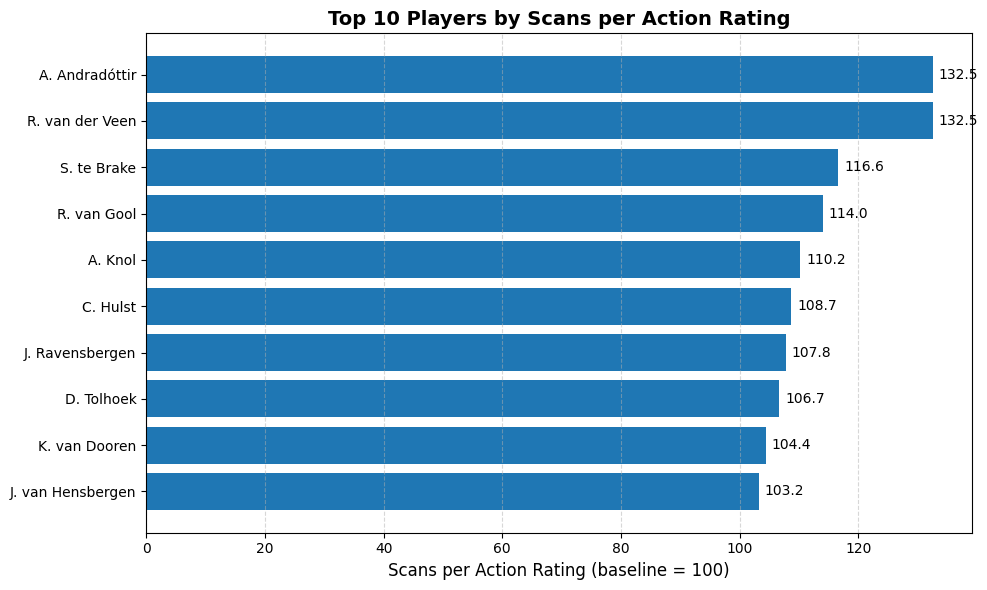

Excel report with scan rating saved to: /content/drive/MyDrive/Outswinger FC/scanning_full_report.xlsx


In [8]:
# ---- STEP 1: MOUNT GOOGLE DRIVE ----
from google.colab import drive
drive.mount('/content/drive')

# ---- STEP 2: IMPORTS ----
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import ExcelWriter

# ---- STEP 3: LOAD CSV FILE ----
file_path = '/content/drive/MyDrive/Outswinger FC/Eredivisie Women 2024-2025/Twente 5-1 Ajax.csv'
df = pd.read_csv(file_path)
df['total_seconds'] = df['timeMin'] * 60 + df['timeSec']
df = df.sort_values(by=['playerId', 'periodId', 'total_seconds'])

# ---- STEP 4: CALCULATE SCAN WINDOWS ----
scan_windows = []
for i in range(1, len(df)):
    current = df.iloc[i]
    prev = df.iloc[i - 1]
    if (
        current['playerId'] == prev['playerId'] and
        current['periodId'] == prev['periodId'] and
        pd.notnull(current['playerId']) and
        pd.notnull(prev['playerId'])
    ):
        time_gap = current['total_seconds'] - prev['total_seconds']
        if time_gap > 1.0:
            raw_scans = int(time_gap // 3.33)
            capped_scans = min(raw_scans, 10)
            scan_windows.append({
                'playerId': current['playerId'],
                'playerName': current['playerName'],
                'periodId': current['periodId'],
                'reception_time': current['total_seconds'],
                'time_since_last_action': time_gap,
                'estimated_scans_raw': raw_scans,
                'estimated_scans_capped': capped_scans
            })

scan_df = pd.DataFrame(scan_windows)

# ---- STEP 5: AGGREGATE PER PLAYER ----
scan_actions = scan_df.groupby('playerName').agg({
    'estimated_scans_raw': 'sum',
    'estimated_scans_capped': 'sum',
    'reception_time': 'count'
}).rename(columns={'reception_time': 'total_actions'})

scan_actions['scans_per_action_raw'] = scan_actions['estimated_scans_raw'] / scan_actions['total_actions']
scan_actions['scans_per_action_capped'] = scan_actions['estimated_scans_capped'] / scan_actions['total_actions']

# ---- STEP 5.1: SCANS PER ACTION RATING (Baseline = 100) ----
mean_value = scan_actions['scans_per_action_capped'].mean()
scan_actions['scans_per_action_rating'] = (
    (scan_actions['scans_per_action_capped'] / mean_value) * 100
).round(1)

# ---- STEP 6: BAR CHART (Top 10 Players by Rating) ----
top_players = scan_actions.sort_values(by='scans_per_action_rating', ascending=False).head(10)

plt.figure(figsize=(10, 6))
bars = plt.barh(top_players.index[::-1], top_players['scans_per_action_rating'][::-1])
plt.xlabel('Scans per Action Rating (baseline = 100)', fontsize=12)
plt.title('Top 10 Players by Scans per Action Rating', fontsize=14, weight='bold')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
for bar in bars:
    width = bar.get_width()
    plt.text(width + 1, bar.get_y() + bar.get_height() / 2,
             f'{width:.1f}', va='center', fontsize=10)
plt.tight_layout()
plt.show()

# ---- STEP 7: SAVE TO EXCEL ----
output_path = '/content/drive/MyDrive/Outswinger FC/scanning_full_report.xlsx'

with ExcelWriter(output_path, engine='xlsxwriter') as writer:
    scan_df.to_excel(writer, sheet_name='Scan Events', index=False)
    scan_actions.to_excel(writer, sheet_name='Scans Per Player')
    workbook = writer.book
    worksheet = workbook.add_worksheet('Scans Chart')
    writer.sheets['Scans Chart'] = worksheet

    # Prepare chart data (rating-based)
    chart_data = top_players[['scans_per_action_rating']].reset_index()
    for row_num, (player, val) in enumerate(zip(chart_data['playerName'], chart_data['scans_per_action_rating']), start=1):
        worksheet.write(row_num, 0, player)
        worksheet.write(row_num, 1, val)

    # Create and insert chart
    chart = workbook.add_chart({'type': 'bar'})
    chart.add_series({
        'name': 'Scans per Action Rating',
        'categories': ['Scans Chart', 1, 0, len(chart_data), 0],
        'values':     ['Scans Chart', 1, 1, len(chart_data), 1],
        'data_labels': {'value': True},
    })
    chart.set_title({'name': 'Top 10 Players: Scans per Action Rating'})
    chart.set_x_axis({'name': 'Rating (100 = Normal)'})
    chart.set_y_axis({'name': 'Player'})
    chart.set_style(11)
    worksheet.insert_chart('D2', chart)

print(f"Excel report with scan rating saved to: {output_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


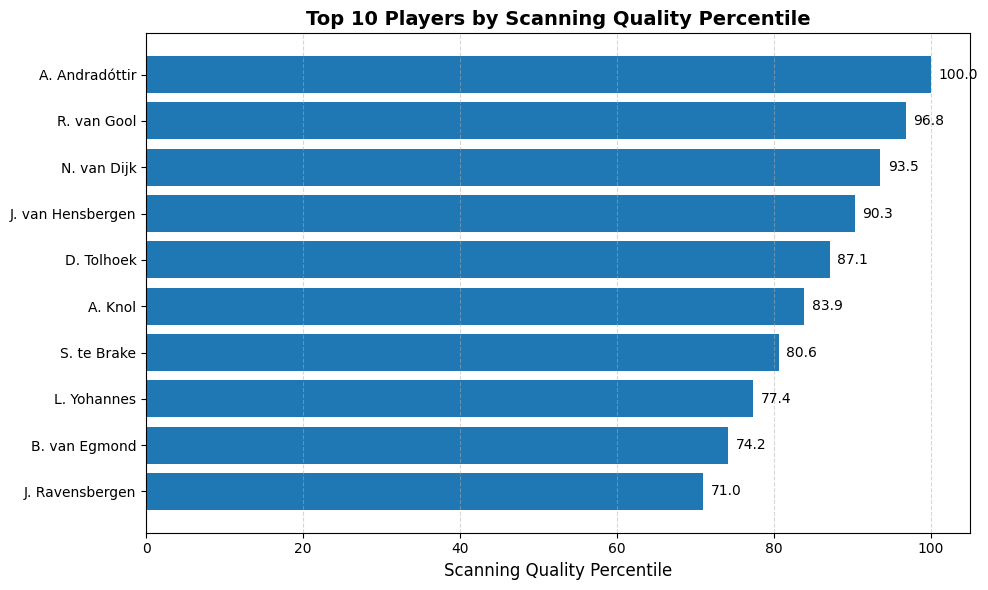

✅ Excel report saved to:
/content/drive/MyDrive/Outswinger FC/scanning_quality_report_with_pass_types.xlsx


In [10]:
# ---- STEP 1: MOUNT GOOGLE DRIVE ----
from google.colab import drive
drive.mount('/content/drive')

# ---- STEP 2: IMPORTS ----
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import ExcelWriter
from scipy.stats import rankdata

# ---- STEP 3: LOAD CSV FILE ----
file_path = '/content/drive/MyDrive/Outswinger FC/Eredivisie Women 2024-2025/Twente 5-1 Ajax.csv'
df = pd.read_csv(file_path)
df['total_seconds'] = df['timeMin'] * 60 + df['timeSec']
df = df.sort_values(by=['playerId', 'periodId', 'total_seconds'])

# ---- STEP 4: CALCULATE SCANNING QUALITY SCORE (ONLY BEFORE PASS) ----
scan_windows = []

# Parameters
max_gap = 15
time_weight = 0.7
position_weight = 0.3

for i in range(1, len(df)):
    current = df.iloc[i]
    prev = df.iloc[i - 1]

    if (
        current['playerId'] == prev['playerId'] and
        current['periodId'] == prev['periodId'] and
        pd.notnull(current['playerId']) and
        pd.notnull(prev['playerId'])
    ):
        time_gap = current['total_seconds'] - prev['total_seconds']

        if time_gap > 1.0:
            # Check if next action is a pass
            next_actions = df[
                (df['playerId'] == current['playerId']) &
                (df['periodId'] == current['periodId']) &
                (df['total_seconds'] > current['total_seconds'])
            ]
            if not next_actions.empty:
                next_event = next_actions.iloc[0]
                if next_event['typeId'] == 1:  # Pass only
                    norm_time_gap = min(time_gap, max_gap) / max_gap
                    x = current['x'] if pd.notnull(current['x']) else 50
                    centrality_score = 1 - abs(x - 50) / 50
                    scan_quality_score = round(
                        time_weight * norm_time_gap + position_weight * centrality_score, 3
                    )

                    # Distance of pass
                    if pd.notnull(next_event['x']) and pd.notnull(next_event['y']) and pd.notnull(current['x']) and pd.notnull(current['y']):
                        dx = next_event['x'] - current['x']
                        dy = next_event['y'] - current['y']
                        pass_distance = np.sqrt(dx**2 + dy**2)

                        if pass_distance < 10:
                            pass_type = 'Short'
                        elif pass_distance <= 30:
                            pass_type = 'Medium'
                        else:
                            pass_type = 'Long'
                    else:
                        pass_type = 'Unknown'
                        pass_distance = None

                    scan_windows.append({
                        'playerId': current['playerId'],
                        'playerName': current['playerName'],
                        'periodId': current['periodId'],
                        'reception_time': current['total_seconds'],
                        'time_since_last_action': time_gap,
                        'centrality_score': round(centrality_score, 2),
                        'norm_time_gap': round(norm_time_gap, 2),
                        'scan_quality_score': scan_quality_score,
                        'pass_type': pass_type,
                        'pass_distance': round(pass_distance, 1) if pass_distance else None
                    })

scan_df = pd.DataFrame(scan_windows)

# ---- STEP 5: PLAYER SUMMARY WITH PERCENTILES ----
scan_actions = scan_df.groupby('playerName').agg({
    'scan_quality_score': 'mean',
    'reception_time': 'count'
}).rename(columns={'reception_time': 'total_pass_actions'})

scan_actions['scan_quality_score'] = (scan_actions['scan_quality_score'] * 100).round(1)
scan_actions['scan_quality_percentile'] = rankdata(scan_actions['scan_quality_score'], method='average') / len(scan_actions) * 100
scan_actions['scan_quality_percentile'] = scan_actions['scan_quality_percentile'].round(1)

# ---- STEP 6: BAR CHART (Top 10 by Percentile) ----
top_players = scan_actions.sort_values(by='scan_quality_percentile', ascending=False).head(10)

plt.figure(figsize=(10, 6))
bars = plt.barh(top_players.index[::-1], top_players['scan_quality_percentile'][::-1])
plt.xlabel('Scanning Quality Percentile', fontsize=12)
plt.title('Top 10 Players by Scanning Quality Percentile', fontsize=14, weight='bold')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
for bar in bars:
    width = bar.get_width()
    plt.text(width + 1, bar.get_y() + bar.get_height() / 2,
             f'{width:.1f}', va='center', fontsize=10)
plt.tight_layout()
plt.show()

# ---- STEP 7: SAVE TO EXCEL ----
output_path = '/content/drive/MyDrive/Outswinger FC/scanning_quality_report_with_pass_types.xlsx'

with ExcelWriter(output_path, engine='xlsxwriter') as writer:
    scan_df.to_excel(writer, sheet_name='Scan Events', index=False)
    scan_actions.to_excel(writer, sheet_name='Player Summary', index=True)
    workbook = writer.book
    worksheet = workbook.add_worksheet('Quality Chart')
    writer.sheets['Quality Chart'] = worksheet

    # Chart data
    chart_data = top_players[['scan_quality_percentile']].reset_index()
    for row_num, (player, val) in enumerate(zip(chart_data['playerName'], chart_data['scan_quality_percentile']), start=1):
        worksheet.write(row_num, 0, player)
        worksheet.write(row_num, 1, val)

    # Create chart
    chart = workbook.add_chart({'type': 'bar'})
    chart.add_series({
        'name': 'Scanning Quality Percentile',
        'categories': ['Quality Chart', 1, 0, len(chart_data), 0],
        'values':     ['Quality Chart', 1, 1, len(chart_data), 1],
        'data_labels': {'value': True},
    })
    chart.set_title({'name': 'Top 10 Players: Scanning Quality Percentile'})
    chart.set_x_axis({'name': 'Percentile'})
    chart.set_y_axis({'name': 'Player'})
    chart.set_style(11)
    worksheet.insert_chart('D2', chart)

print(f"✅ Excel report saved to:\n{output_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


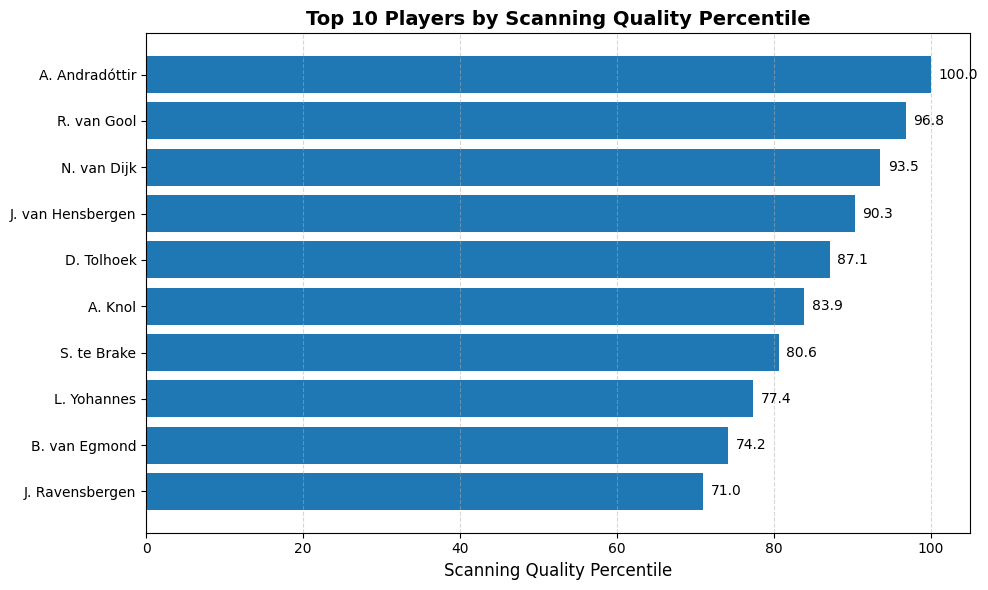

✅ Excel report saved to:
/content/drive/MyDrive/Outswinger FC/scanning_quality_report_with_pass_types.xlsx


In [11]:
# ---- STEP 1: MOUNT GOOGLE DRIVE ----
from google.colab import drive
drive.mount('/content/drive')

# ---- STEP 2: IMPORTS ----
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import ExcelWriter
from scipy.stats import rankdata

# ---- STEP 3: LOAD CSV FILE ----
file_path = '/content/drive/MyDrive/Outswinger FC/Eredivisie Women 2024-2025/Twente 5-1 Ajax.csv'
df = pd.read_csv(file_path)
df['total_seconds'] = df['timeMin'] * 60 + df['timeSec']
df = df.sort_values(by=['playerId', 'periodId', 'total_seconds'])

# ---- STEP 4: CALCULATE SCANNING QUALITY SCORE (ONLY BEFORE PASS) ----
scan_windows = []
max_gap = 15
time_weight = 0.7
position_weight = 0.3

for i in range(1, len(df)):
    current = df.iloc[i]
    prev = df.iloc[i - 1]

    if (
        current['playerId'] == prev['playerId'] and
        current['periodId'] == prev['periodId'] and
        pd.notnull(current['playerId']) and
        pd.notnull(prev['playerId'])
    ):
        time_gap = current['total_seconds'] - prev['total_seconds']

        if time_gap > 1.0:
            next_actions = df[
                (df['playerId'] == current['playerId']) &
                (df['periodId'] == current['periodId']) &
                (df['total_seconds'] > current['total_seconds'])
            ]
            if not next_actions.empty:
                next_event = next_actions.iloc[0]
                if next_event['typeId'] == 1:  # Pass only
                    norm_time_gap = min(time_gap, max_gap) / max_gap
                    x = current['x'] if pd.notnull(current['x']) else 50
                    centrality_score = 1 - abs(x - 50) / 50
                    scan_quality_score = round(
                        time_weight * norm_time_gap + position_weight * centrality_score, 3
                    )

                    if pd.notnull(next_event['x']) and pd.notnull(next_event['y']) and pd.notnull(current['x']) and pd.notnull(current['y']):
                        dx = next_event['x'] - current['x']
                        dy = next_event['y'] - current['y']
                        pass_distance = np.sqrt(dx**2 + dy**2)

                        if pass_distance < 10:
                            pass_type = 'Short'
                        elif pass_distance <= 30:
                            pass_type = 'Medium'
                        else:
                            pass_type = 'Long'
                    else:
                        pass_type = 'Unknown'
                        pass_distance = None

                    scan_windows.append({
                        'playerId': current['playerId'],
                        'playerName': current['playerName'],
                        'periodId': current['periodId'],
                        'reception_time': current['total_seconds'],
                        'time_since_last_action': time_gap,
                        'centrality_score': round(centrality_score, 2),
                        'norm_time_gap': round(norm_time_gap, 2),
                        'scan_quality_score': scan_quality_score,
                        'pass_type': pass_type,
                        'pass_distance': round(pass_distance, 1) if pass_distance else None
                    })

scan_df = pd.DataFrame(scan_windows)

# ---- STEP 5: PLAYER SUMMARY WITH PERCENTILES ----
scan_actions = scan_df.groupby('playerName').agg({
    'scan_quality_score': 'mean',
    'reception_time': 'count'
}).rename(columns={'reception_time': 'total_pass_actions'})

scan_actions['scan_quality_score'] = (scan_actions['scan_quality_score'] * 100).round(1)
scan_actions['scan_quality_percentile'] = rankdata(scan_actions['scan_quality_score'], method='average') / len(scan_actions) * 100
scan_actions['scan_quality_percentile'] = scan_actions['scan_quality_percentile'].round(1)

# ---- STEP 5.1: GROUP SCANNING BY PASS TYPE ----
scan_by_pass_type = scan_df.groupby(['playerName', 'pass_type']).agg({
    'scan_quality_score': 'mean',
    'reception_time': 'count'
}).rename(columns={'scan_quality_score': 'avg_scan_quality', 'reception_time': 'pass_count'})

scan_by_pass_type['avg_scan_quality'] = (scan_by_pass_type['avg_scan_quality'] * 100).round(1)

scan_by_pass_type = scan_by_pass_type.reset_index()
scan_by_pass_type['scan_quality_percentile'] = scan_by_pass_type.groupby('pass_type')['avg_scan_quality'].rank(pct=True) * 100
scan_by_pass_type['scan_quality_percentile'] = scan_by_pass_type['scan_quality_percentile'].round(1)

# ---- STEP 6: BAR CHART (Top 10 by Percentile) ----
top_players = scan_actions.sort_values(by='scan_quality_percentile', ascending=False).head(10)

plt.figure(figsize=(10, 6))
bars = plt.barh(top_players.index[::-1], top_players['scan_quality_percentile'][::-1])
plt.xlabel('Scanning Quality Percentile', fontsize=12)
plt.title('Top 10 Players by Scanning Quality Percentile', fontsize=14, weight='bold')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
for bar in bars:
    width = bar.get_width()
    plt.text(width + 1, bar.get_y() + bar.get_height() / 2,
             f'{width:.1f}', va='center', fontsize=10)
plt.tight_layout()
plt.show()

# ---- STEP 7: SAVE TO EXCEL ----
output_path = '/content/drive/MyDrive/Outswinger FC/scanning_quality_report_with_pass_types.xlsx'

with ExcelWriter(output_path, engine='xlsxwriter') as writer:
    scan_df.to_excel(writer, sheet_name='Scan Events', index=False)
    scan_actions.to_excel(writer, sheet_name='Player Summary', index=True)
    scan_by_pass_type.to_excel(writer, sheet_name='By Pass Type', index=False)

    workbook = writer.book
    worksheet = workbook.add_worksheet('Quality Chart')
    writer.sheets['Quality Chart'] = worksheet

    # Chart data
    chart_data = top_players[['scan_quality_percentile']].reset_index()
    for row_num, (player, val) in enumerate(zip(chart_data['playerName'], chart_data['scan_quality_percentile']), start=1):
        worksheet.write(row_num, 0, player)
        worksheet.write(row_num, 1, val)

    # Create chart
    chart = workbook.add_chart({'type': 'bar'})
    chart.add_series({
        'name': 'Scanning Quality Percentile',
        'categories': ['Quality Chart', 1, 0, len(chart_data), 0],
        'values':     ['Quality Chart', 1, 1, len(chart_data), 1],
        'data_labels': {'value': True},
    })
    chart.set_title({'name': 'Top 10 Players: Scanning Quality Percentile'})
    chart.set_x_axis({'name': 'Percentile'})
    chart.set_y_axis({'name': 'Player'})
    chart.set_style(11)
    worksheet.insert_chart('D2', chart)

print(f"✅ Excel report saved to:\n{output_path}")
